## DCP Internship
#### Reading in SafeGraph Data
##### Part 1: Quantifying/Determining sample bias in NYC only
    - NOTE: this is using the safegraph python notebook as a reference. Credit to SafeGraph

In [1]:
# make display wider
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:88% !important; }</style>"))

In [2]:
#reading in relevant libs
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import s3fs
import os
import time

C:\Users\steve\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from safegraph_py_functions import safegraph_py_functions as sgpy
#from geo import stco, sub

In [4]:
#ensuring sgpy works
sgpy.test_me()

Hello World


In [11]:
# allow max rows and colums to be displayed
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# read in CBG for join
cbg_nyc = pd.read_csv(r'C..data\nyc_cbg.csv')
 # cbg_nyc.csv')
cbg_nyc.head()
# read in geowalk for join
geowalk = pd.read_csv(r'..nyc_geo_xwalk.csv')
# read in ACS estimates
acs_nta = pd.read_csv(r'..acs_nta.csv')
geowalk = pd.merge(geowalk, acs_nta, left_on="orig_nta", right_on="orig_nta", how="inner")
geowalk.head(5)

,Pop_10E,orig_st,orig_co,orig_cbg,orig_ctract,orig_nta,orig_puma,orig_subbor,orig_stco,Asian_C,Asian_E,Asian_M,Black_C,Black_E,Black_M,Hispanic_C,Hispanic_E,Hispanic_M,Other_C,Other_E,Other_M,Pop_C,Pop_E,Pop_M,White_C,White_E,White_M
0,0,36,5,360050001000,36005000100,BX98,3603710,36005CS,36005,25.479756,125.0,52.392748,4.123890,3984.0,270.266535,6.480733,2329.0,248.290153,35.487747,104.0,60.712437,2.492128,7080.0,290.248170,18.129667,538.0,160.449369
1,11091,36,5,360050001001,36005000100,BX98,3603710,36005CS,36005,25.479756,125.0,52.392748,4.123890,3984.0,270.266535,6.480733,2329.0,248.290153,35.487747,104.0,60.712437,2.492128,7080.0,290.248170,18.129667,538.0,160.449369
2,0,36,5,360050002000,36005000200,BX09,3603709,36005CS,36005,21.921885,692.0,249.545587,6.237077,18751.0,1923.851086,4.425945,33187.0,2416.239227,26.837758,809.0,357.158228,3.222825,54925.0,2911.874654,20.956139,1486.0,512.266532
3,1120,36,5,360050002001,36005000200,BX09,3603709,36005CS,36005,21.921885,692.0,249.545587,6.237077,18751.0,1923.851086,4.425945,33187.0,2416.239227,26.837758,809.0,357.158228,3.222825,54925.0,2911.874654,20.956139,1486.0,512.266532
4,1974,36,5,360050002002,36005000200,BX09,3603709,36005CS,36005,21.921885,692.0,249.545587,6.237077,18751.0,1923.851086,4.425945,33187.0,2416.239227,26.837758,809.0,357.158228,3.222825,54925.0,2911.874654,20.956139,1486.0,512.266532


In [14]:
# read in the Neighborhood names for NTA codes
NTA_names = pd.read_csv(r'..Neighborhoods.csv')
NTA_names
NTA_names['Name'] = NTA_names['Name'].str.replace('-',' ') # replace - value with space
NTA_names = NTA_names.rename({'NTA \nCode':'code', 'Name':'name'}, axis = 1) # rename columns
NTA_names = NTA_names.drop_duplicates(subset = ['code'])
len(NTA_names)

195

In [15]:
# Specifying SafeGraph keys --
myAccessKey = os.environ.get('SafeGraph_Access')
mySecretKey = os.environ.get('SafeGraph_Secret')
fs = s3fs.S3FileSystem(key=myAccessKey, secret=mySecretKey, client_kwargs={'endpoint_url': 'https://s3.wasabisys.com', 'region_name':'us-east-1'})

In [16]:
y1, y2 = '2019', '2020'
# define months/days
# for iterating through all 
monthList =["01","02","03","04","05","06", "07","08"]
dayNumList =[31, 29, 31, 30, 31, 30, 31, 31]
years = ["2019","2020"]
dayList =["01","02","03","04","05","06","07","08","09","10","11","12","13","14","15","16","17","18","19","20","21","22","23","24","25","26","27","28","29","30","31"]


___________________________________________________________________
WEEKLY LOCKDOWN (first seven days of each month from Jan - Aug 2020)

In [27]:
# for loop, m is all month, i is all days in first week
weeks = []
for m in range(0,8):
    for i in range (0,7):
        with fs.open(f'sg-c19-response/social-distancing/v2/{y2}/{monthList[m]}/{dayList[i]}/{y2}-{monthList[m]}-{dayList[i]}-social-distancing.csv.gz','rb') as file:
            print(f'{monthList[m]}-{dayList[i]}')
             # read SG's file
            df = pd.read_csv(file, escapechar = '\\', compression = 'gzip')
            #filter NYC origin CBGs
            df_2 = pd.merge(geowalk, df, left_on="orig_cbg", right_on="origin_census_block_group", how="inner")
            # clean up time, make month and day into own columns
            date = df_2['date_range_start'].str.split('T', n = 1, expand = True)
            df_2['date_st'] = date[0]
            df_2['date_st'] = pd.to_datetime(df_2['date_st'], format = '%Y-%m-%d')
            df_2['day'] = df_2['date_st'].dt.day
            df_2['month'] =  df_2['date_st'].dt.month
            df_2[['day','month']] = df_2[['day','month']].apply(pd.to_numeric)
            weeks.append(df_2) # append the completed dataframes together into a list called `weeks`

01-01
01-02
01-03
01-04
01-05
01-06
01-07
02-01
02-02
02-03
02-04
02-05
02-06
02-07
03-01
03-02
03-03
03-04
03-05
03-06
03-07
04-01
04-02
04-03
04-04
04-05
04-06
04-07
05-01
05-02
05-03
05-04
05-05
05-06
05-07
06-01
06-02
06-03
06-04
06-05
06-06
06-07
07-01
07-02
07-03
07-04
07-05
07-06
07-07
08-01
08-02
08-03
08-04
08-05
08-06
08-07


In [28]:
df = pd.concat(weeks)

In [29]:
# check length to ensure all files are read in along with join
len(df)

350463

In [30]:
# view join
df.head(10)

,Pop_10E,orig_st,orig_co,orig_cbg,orig_ctract,orig_nta,orig_puma,orig_subbor,orig_stco,Asian_C,Asian_E,Asian_M,Black_C,Black_E,Black_M,Hispanic_C,Hispanic_E,Hispanic_M,Other_C,Other_E,Other_M,Pop_C,Pop_E,Pop_M,White_C,White_E,White_M,origin_census_block_group,date_range_start,date_range_end,device_count,distance_traveled_from_home,bucketed_distance_traveled,median_dwell_at_bucketed_distance_traveled,completely_home_device_count,median_home_dwell_time,bucketed_home_dwell_time,at_home_by_each_hour,part_time_work_behavior_devices,full_time_work_behavior_devices,destination_cbgs,delivery_behavior_devices,median_non_home_dwell_time,candidate_device_count,bucketed_away_from_home_time,median_percentage_time_home,bucketed_percentage_time_home,date_st,day,month,mean_home_dwell_time,mean_non_home_dwell_time,mean_distance_traveled_from_home
0,11091,36,5,360050001001,36005000100,BX98,3603710,36005CS,36005,25.479756,125.0,52.392748,4.123890,3984.0,270.266535,6.480733,2329.0,248.290153,35.487747,104.0,60.712437,2.492128,7080.0,290.248170,18.129667,538.0,160.449369,360050001001,2020-01-01T00:00:00-05:00,2020-01-02T00:00:00-05:00,8,13031.0,"{""16001-50000"":1,"">50000"":1,""2001-8000"":1,""800...","{"">50000"":672,""16001-50000"":22,""2001-8000"":55,...",1,56,"{""<60"":1,""361-720"":1,""61-360"":5}","[2,1,2,2,3,3,6,2,2,1,1,0,0,0,0,0,0,0,0,0,0,1,1,2]",1,1,"{""360470449002"":1,""360810125001"":1,""3611900020...",1,135,14,"{""21-45"":1,""46-60"":1,""721-840"":1,""1201-1320"":1...",41,"{""0-25"":4,""51-75"":4,""26-50"":1}",2020-01-01,1,1,NaN,NaN,NaN
1,1120,36,5,360050002001,36005000200,BX09,3603709,36005CS,36005,21.921885,692.0,249.545587,6.237077,18751.0,1923.851086,4.425945,33187.0,2416.239227,26.837758,809.0,357.158228,3.222825,54925.0,2911.874654,20.956139,1486.0,512.266532,360050002001,2020-01-01T00:00:00-05:00,2020-01-02T00:00:00-05:00,54,2904.0,"{""16001-50000"":5,""0"":24,"">50000"":1,""2001-8000""...","{""16001-50000"":248,"">50000"":587,""<1000"":37,""20...",25,840,"{""721-1080"":6,""361-720"":7,""61-360"":6,""<60"":9,""...","[20,19,19,28,26,29,28,32,29,32,33,32,31,36,34,...",1,1,"{""360050127011"":1,""360050285004"":1,""3600500720...",1,6,102,"{""21-45"":2,""481-540"":1,""721-840"":4,""<20"":27,""6...",99,"{""26-50"":4,""51-75"":1,""0-25"":9,"">100"":3,""76-100...",2020-01-01,1,1,NaN,NaN,NaN
2,1974,36,5,360050002002,36005000200,BX09,3603709,36005CS,36005,21.921885,692.0,249.545587,6.237077,18751.0,1923.851086,4.425945,33187.0,2416.239227,26.837758,809.0,357.158228,3.222825,54925.0,2911.874654,20.956139,1486.0,512.266532,360050002002,2020-01-01T00:00:00-05:00,2020-01-02T00:00:00-05:00,111,4414.0,"{""16001-50000"":7,""0"":44,"">50000"":3,""2001-8000""...","{""16001-50000"":103,"">50000"":18,""<1000"":110,""20...",42,456,"{""721-1080"":17,""361-720"":10,""61-360"":16,""<60"":...","[41,43,49,50,53,57,56,55,50,50,47,45,47,47,44,...",1,1,"{""360610232002"":1,""360050127011"":1,""3600502090...",1,14,255,"{""21-45"":6,""481-540"":2,""541-600"":2,""46-60"":1,""...",93,"{""26-50"":5,""51-75"":9,""0-25"":27,"">100"":1,""76-10...",2020-01-01,1,1,NaN,NaN,NaN
3,1240,36,5,360050002003,36005000200,BX09,3603709,36005CS,36005,21.921885,692.0,249.545587,6.237077,18751.0,1923.851086,4.425945,33187.0,2416.239227,26.837758,809.0,357.158228,3.222825,54925.0,2911.874654,20.956139,1486.0,512.266532,360050002003,2020-01-01T00:00:00-05:00,2020-01-02T00:00:00-05:00,55,4467.0,"{""16001-50000"":3,""0"":20,"">50000"":2,""2001-8000""...","{""16001-50000"":51,"">50000"":53,""<1000"":29,""2001...",21,826,"{""721-1080"":8,""361-720"":9,""61-360"":5,""<60"":12,...","[22,31,26,32,34,35,32,25,34,34,33,33,29,27,30,...",3,1,"{""340030234021"":1,""360610154009"":1,""3600500900...",1,15,104,"{""21-45"":3,""541-600"":1,""46-60"":2,""721-840"":2,""...",97,"{""26-50"":3,""51-75"":6,""0-25"":14,"">100"":1,""76-10...",2020-01-01,1,1,NaN,NaN,NaN
4,0,36,5,360050004000,36005000400,BX09,3603709,36005CS,36005,21.921885,692.0,249.545587,6.237077,18751.0,1923.851086,4.425945,33187.0,2416.

In [31]:
# create objects aggregated from NTA boro level
# aggregate population by the NTA code and month data was taken
nta_geo = df.groupby(['month','orig_nta'], as_index = False # only aggregating by month allows for summarization for each week
                         ).agg(
                            {'Pop_10E':'sum',
                             'Pop_E': 'mean',
                             'Asian_E':'mean',
                             'Black_E':'mean',
                             'Hispanic_E':'mean',
                             'Other_E':'mean',
                             'White_E':'mean',
                             'device_count':'sum',
                             'candidate_device_count':'sum', 
                             # sum allows for a summarization for each nta geography
                             'orig_cbg':'mean'}) # add census block group counts.
nta_geo.head(10)

,month,orig_nta,Pop_10E,Pop_E,Asian_E,Black_E,Hispanic_E,Other_E,White_E,device_count,candidate_device_count,orig_cbg
0,1,BK09,160209,24168.0,2236.0,1400.0,1770.0,1224.0,17538.0,4862,10571,3.604700e+11
1,1,BK17,451626,65631.0,12973.0,4254.0,6021.0,1440.0,40943.0,29835,51261,3.604706e+11
2,1,BK19,248829,34431.0,4745.0,234.0,3673.0,1255.0,24524.0,15996,29414,3.604704e+11
3,1,BK21,223755,32259.0,2808.0,9430.0,8992.0,789.0,10240.0,13063,27143,3.604703e+11
4,1,BK23,124250,16774.0,139.0,280.0,660.0,170.0,15525.0,7103,11557,3.604704e+11
5,1,BK25,310212,45007.0,4427.0,868.0,5294.0,1661.0,32757.0,17417,29834,3.604705e+11
6,1,BK26,206052,30587.0,7118.0,2300.0,6396.0,1262.0,13511.0,12946,24171,3.604704e+11
7,1,BK27,209517,33020.0,12242.0,368.0,5975.0,840.0,13595.0,13409,23072,3.604702e+11
8,1,BK28,621089,90847.0,38064.0,831.0,15263.0,1641.0,35048.0,34571,61215,3.604703e+11
9,1,BK29,440846,65502.0,26887.0,654.0,8855.0,1560.0,27546.0,25024,42525,3.604704e+11


In [32]:
# divide summarized fields by total number of days
nta_geo['Pop_10E'] = nta_geo['Pop_10E']/7
nta_geo['device_count'] = nta_geo['device_count']/7
nta_geo['candidate_device_count'] = nta_geo['candidate_device_count']/7

In [33]:
print('Number of Neighborhoods: ',len(nta_geo))
nta_geo.head(5)

Number of Neighborhoods:  1558


,month,orig_nta,Pop_10E,Pop_E,Asian_E,Black_E,Hispanic_E,Other_E,White_E,device_count,candidate_device_count,orig_cbg
0,1,BK09,22887.0,24168.0,2236.0,1400.0,1770.0,1224.0,17538.0,694.571429,1510.142857,3.604700e+11
1,1,BK17,64518.0,65631.0,12973.0,4254.0,6021.0,1440.0,40943.0,4262.142857,7323.000000,3.604706e+11
2,1,BK19,35547.0,34431.0,4745.0,234.0,3673.0,1255.0,24524.0,2285.142857,4202.000000,3.604704e+11
3,1,BK21,31965.0,32259.0,2808.0,9430.0,8992.0,789.0,10240.0,1866.142857,3877.571429,3.604703e+11
4,1,BK23,17750.0,16774.0,139.0,280.0,660.0,170.0,15525.0,1014.714286,1651.000000,3.604704e+11


In [34]:
# join the NTA_geo table with the names, clean names for display purposes
nta_geo = pd.merge(nta_geo, NTA_names, how = 'left', left_on = 'orig_nta', right_on = 'code')
nta_geo = nta_geo.drop(['code'], axis = 1)
nta_geo

,month,orig_nta,Pop_10E,Pop_E,Asian_E,Black_E,Hispanic_E,Other_E,White_E,device_count,candidate_device_count,orig_cbg,name
0,1,BK09,22887.000000,24168.0,2236.0,1400.0,1770.0,1224.0,17538.0,694.571429,1510.142857,3.604700e+11,Brooklyn Heights Cobble Hill
1,1,BK17,64518.000000,65631.0,12973.0,4254.0,6021.0,1440.0,40943.0,4262.142857,7323.000000,3.604706e+11,Sheepshead Bay Gerritsen Beach Manhattan Beach
2,1,BK19,35547.000000,34431.0,4745.0,234.0,3673.0,1255.0,24524.0,2285.142857,4202.000000,3.604704e+11,Brighton Beach
3,1,BK21,31965.000000,32259.0,2808.0,9430.0,8992.0,789.0,10240.0,1866.142857,3877.571429,3.604703e+11,Seagate Coney Island
4,1,BK23,17750.000000,16774.0,139.0,280.0,660.0,170.0,15525.0,1014.714286,1651.000000,3.604704e+11,West Brighton
5,1,BK25,44316.000000,45007.0,4427.0,868.0,5294.0,1661.0,32757.0,2488.142857,4262.000000,3.604705e+11,Homecrest
6,1,BK26,29436.000000,30587.0,7118.0,2300.0,6396.0,1262.0,13511.0,1849.428571,3453.000000,3.604704e+11,Gravesend
7,1,BK27,29931.000000,33020.0,12242.0,368.0,5975.0,840.0,13595.0,1915.571429,3296.000000,3.604702e+11,Bath Beach
8,1,BK28,88727.000000,90847.0,38064.0,831.0,15263.0,1641.0,35048.0,4938.714286,8745.000000,3.604703e+11,Bensonhurst West
9,1,BK29,62978.000000,65502.0,26887.0,654.0,8855.0,1560.0,27546.0,3574.857143,6075.000000,3.604704e+11,Bensonhurst East


### Quantifying sampling bias by geographies
    - Bias = observed_proportion − expected_proportion

In [35]:
# functions, with help of safegraph to compute bias & plot sg vs geographies
# CREDIT to safegraph for graphing functions
def compute_bias(df, sample_col = 'candidate_device_count', pop_col = 'Pop_E'):
    obs_proportion = df[sample_col]/df[sample_col].sum()*100 # take one record's candidate devices, divide by total devices within dataset
    exp_proportion = df[pop_col]/df[pop_col].sum()*100       # take one record's population, divide by total population of dataset 
    bias = obs_proportion - exp_proportion # candidate proportion - the population proportion
    return(bias) # return bias value for each record

def make_center_line_coords(df,x,y):
  # This creates two coords to define the hypothetical line in which x and y are perfectly correlatd
    expected_slope = df[y].sum()/df[x].sum()
    xcoord = np.array([df[x].min(), df[x].max()])
    ycoord = expected_slope*xcoord
    return((xcoord,ycoord))
  
def summarize_bias(df,bias_col):
    sum_abs_bias = np.absolute(df[bias_col]).sum()
    print("Sum Absolute Bias: {0:.2f}".format(sum_abs_bias))
    return(None)

def plot_sg_vs_geos(df, xvar, yvar,bias_col='bias' or 'bias_device',xlim_=None,ylim_=None,text_col=None, num_to_label=5,alpha=0.9,labelfontsize=11):
  # `text_col` is the column used to annotate the points
  # `num_to_label` sets the top num_to_label records sorted by yvar to be annotated
    plt.rcParams['figure.figsize'] = [11, 9]
        
     # Report Stats
    pearson_r = df.corr().loc[xvar, yvar]
    print("pearson r: {0:.3f}".format(pearson_r))
    summarize_bias(df,bias_col)
  # scatter plot
    ax = df.plot.scatter(xvar, yvar, alpha = alpha, edgecolor = 'blue', xlim = xlim_, ylim = ylim_)
    # this will print a text within the plot showing the correlation for each month.
    ax.text(0.05, 0.89, 'pearson r: {0:.3f}'.format(pearson_r), horizontalalignment='left', verticalalignment = 'bottom', transform=ax.transAxes, fontsize = 11, color = 'r')
   # ax.text(0.05, 0.85, 'Sum Absolute Bias: {0:.2f}'.format(summarize_bias), horizontalalignment='left', verticalalignment = 'bottom', transform=ax.transAxes, fontsize = 11, color = 'r')
  # annotate 
    xadj = df[xvar].min()*0.03
    if(text_col is not None):
        for i, point in df.sort_values(by=yvar,ascending=False).iloc[0:num_to_label].iterrows():
            ax.text(point[xvar] + xadj, point[yvar], str(point[text_col]),fontsize=labelfontsize, horizontalalignment = 'left',verticalalignment='bottom')
  # plot expectation line
    line_coords = make_center_line_coords(df,xvar,yvar)
    plt.plot(line_coords[0],line_coords[1], color = 'red',linestyle='-', linewidth=1)
    return(ax)


In [36]:
# NTA sampling bias on both `candidate_device_count` and `device_count`
df_nta = nta_geo.copy()
df_nta['bias'] = compute_bias(df_nta, sample_col = 'candidate_device_count', pop_col = 'Pop_E') # use function defined above
df_nta['bias_device'] = compute_bias(df_nta, sample_col = 'device_count', pop_col = 'Pop_E') 
print(df_nta.shape) # check to ensure column added


(1558, 15)


In [37]:
# print cbgs with largest absolute bias
df_nta['abs_bias'] = np.absolute(df_nta.bias) # using numpy to find absolute value of bias
df_nta['abs_bias_device'] = np.absolute(df_nta.bias_device) # using numpy to find absolute value of bias
df_nta.sort_values(by = 'abs_bias_device', ascending = False).head(10) # find 10 highest bias

,month,orig_nta,Pop_10E,Pop_E,Asian_E,Black_E,Hispanic_E,Other_E,White_E,device_count,candidate_device_count,orig_cbg,name,bias,bias_device,abs_bias,abs_bias_device
1468,8,MN24,42742.000000,42698.0,9160.0,937.0,2697.0,1630.0,28274.0,7164.142857,27729.142857,3.606100e+11,SoHo TriBeCa Civic Center Little Italy,0.353166,0.178515,0.353166,0.178515
1263,7,MN12,132258.571429,132455.0,9694.0,7852.0,22033.0,3732.0,89144.0,2624.428571,5597.428571,3.606102e+11,Upper West Side,-0.112035,-0.107535,0.112035,0.107535
873,5,MN12,132378.000000,132455.0,9694.0,7852.0,22033.0,3732.0,89144.0,2734.857143,6234.000000,3.606102e+11,Upper West Side,-0.102477,-0.103809,0.102477,0.103809
1068,6,MN12,132378.000000,132455.0,9694.0,7852.0,22033.0,3732.0,89144.0,2835.714286,7275.000000,3.606102e+11,Upper West Side,-0.086845,-0.100406,0.086845,0.100406
1458,8,MN12,131276.285714,132455.0,9694.0,7852.0,22033.0,3732.0,89144.0,3007.000000,6128.714286,3.606102e+11,Upper West Side,-0.104058,-0.094626,0.104058,0.094626
1212,7,BK88,99204.428571,102494.0,13253.0,1059.0,8776.0,808.0,78598.0,1922.571429,4214.571429,3.604703e+11,Borough Park,-0.088446,-0.086862,0.088446,0.086862
822,5,BK88,99939.857143,102494.0,13253.0,1059.0,8776.0,808.0,78598.0,1985.285714,4669.000000,3.604703e+11,Borough Park,-0.081622,-0.084746,0.081622,0.084746
44,1,BK88,102272.857143,102494.0,13253.0,1059.0,8776.0,808.0,78598.0,1985.428571,3869.285714,3.604703e+11,Borough Park,-0.093631,-0.084741,0.093631,0.084741
628,4,BK88,101956.142857,102494.0,13253.0,1059.0,8776.0,808.0,78598.0,2002.285714,4794.857143,3.604703e+11,Borough Park,-0.079733,-0.084172,0.079733,0.084172
1407,8,BK88,95862.714286,102494.0,13253.0,1059.0,8776.0,808.0,78598.0,2079.857143,4195.285714,3.604703e+11,Borough Park,-0.088736,-0.081555,0.088736,0.081555


In [38]:
nta_avg = df_nta['abs_bias'].mean()
nta_device_avg =  df_nta['abs_bias_device'].mean()
print('Average candidate device count bias in New York City NTA is: {:0.3f}'.format(nta_avg))
print('Average device count bias in New York City NTA is: {:0.3f}'.format(nta_device_avg))

Average candidate device count bias in New York City NTA is: 0.016
Average device count bias in New York City NTA is: 0.016


In [39]:
# splitting df by month -- to be extracted as csv files for further analysis in Excel
jan_nta = df_nta[(df_nta['month'] == 1)]
feb_nta = df_nta[(df_nta['month'] == 2)]
mar_nta = df_nta[(df_nta['month'] == 3)]
apr_nta = df_nta[(df_nta['month'] == 4)]
may_nta = df_nta[(df_nta['month'] == 5)]
jun_nta = df_nta[(df_nta['month'] == 6)]
jul_nta = df_nta[(df_nta['month'] == 7)]
aug_nta = df_nta[(df_nta['month'] == 8)]

In [40]:
# Average Biases for first 7 days of month by month
avg_bias = df_nta.groupby('month').abs_bias.mean()
device_ct_bias = df_nta.groupby('month').abs_bias_device.mean()
print(avg_bias, device_ct_bias)

month
1    0.011595
2    0.014268
3    0.014465
4    0.017170
5    0.015689
6    0.018818
7    0.018357
8    0.019656
Name: abs_bias, dtype: float64 month
1    0.012816
2    0.015998
3    0.015257
4    0.014820
5    0.016004
6    0.016524
7    0.016982
8    0.018556
Name: abs_bias_device, dtype: float64


In [42]:
# create a dictionary with a key value pair. Key is number of month, value is name of month
month_dict = {'1':'January',
              '2':'February',
              '3':'March',
              '4':'April',
              '5':'May',
              '6':'June',
              '7':'July',
              '8':'August'}
# defining the function to make scatter plot
def make_scatter_candidate(df, month):
        print('NTA-level sampling bias')
        alpha_level = 0.45 # point transparency, 45%
        ax = plot_sg_vs_geos(df, 'Pop_E', 'candidate_device_count', num_to_label = 3, text_col = 'name',alpha = alpha_level)
        ax.set_title(f'NTA Sampling Bias, First week of {mn} 2020', color = 'k',  fontsize = 15)
        ax.set_xlabel(xlabel = '2010 Census Population',color = 'k',  fontsize = 13)
        ax.set_ylabel(ylabel = 'Candidate Devices', color = 'k',  fontsize = 13)
        plt.savefig(f'scatterplots/NTA_candidate_scatter_{mn}.jpg') # saving each scatter plot by month

NTA-level sampling bias
pearson r: 0.845
Sum Absolute Bias: 2.25
NTA-level sampling bias
pearson r: 0.845
Sum Absolute Bias: 2.78
NTA-level sampling bias
pearson r: 0.814
Sum Absolute Bias: 2.82
NTA-level sampling bias
pearson r: 0.685
Sum Absolute Bias: 3.33
NTA-level sampling bias
pearson r: 0.732
Sum Absolute Bias: 3.06
NTA-level sampling bias
pearson r: 0.673
Sum Absolute Bias: 3.67
NTA-level sampling bias
pearson r: 0.651
Sum Absolute Bias: 3.58
NTA-level sampling bias
pearson r: 0.544
Sum Absolute Bias: 3.83


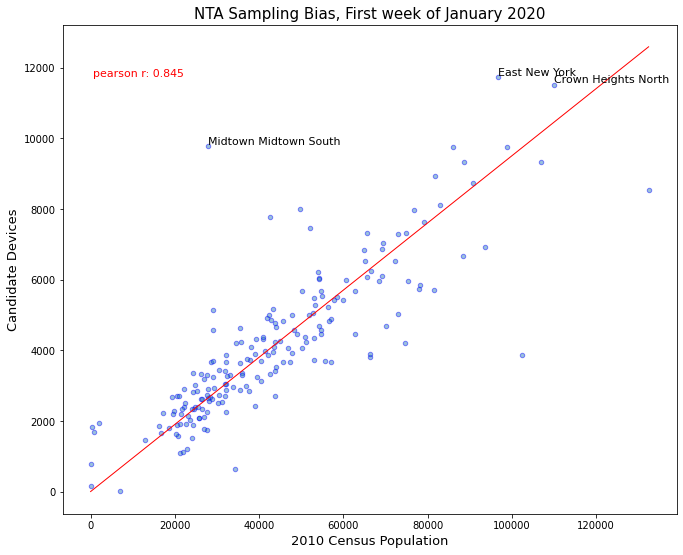

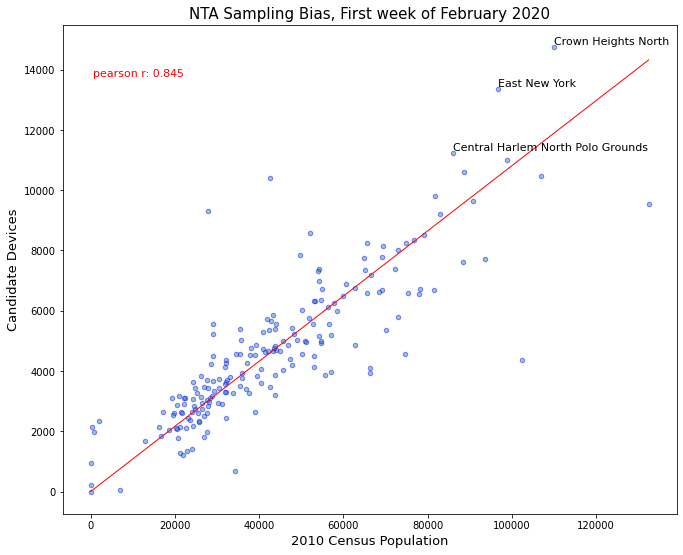

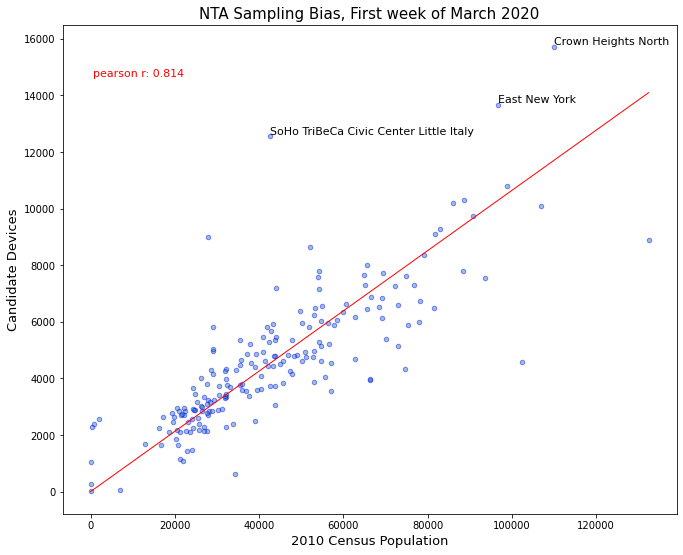

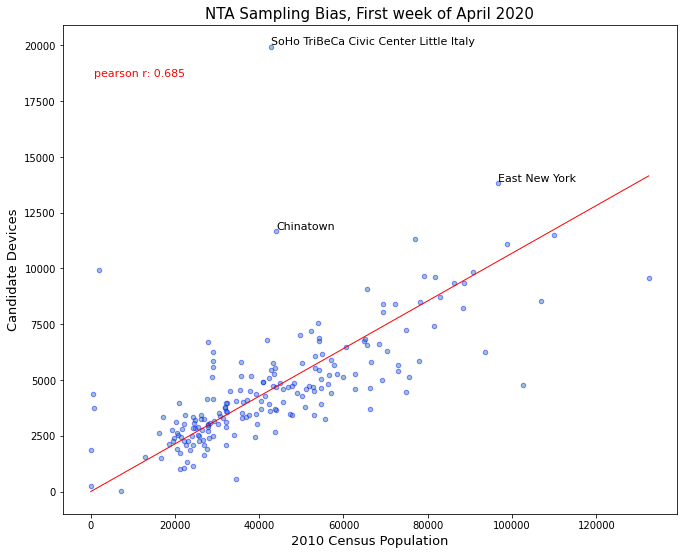

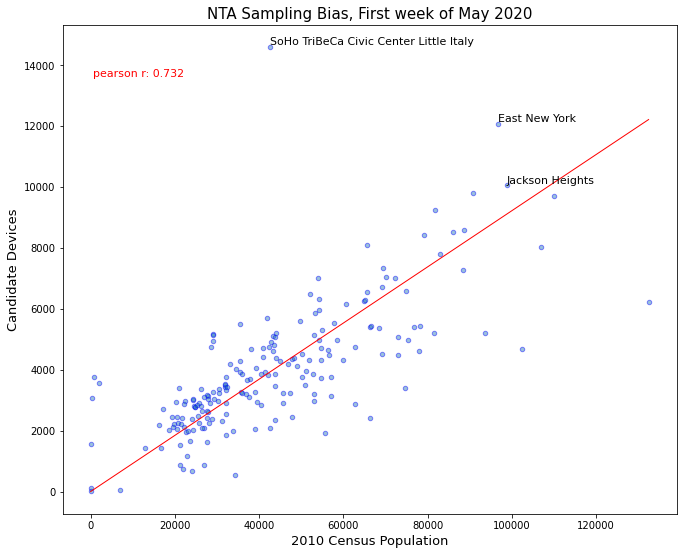

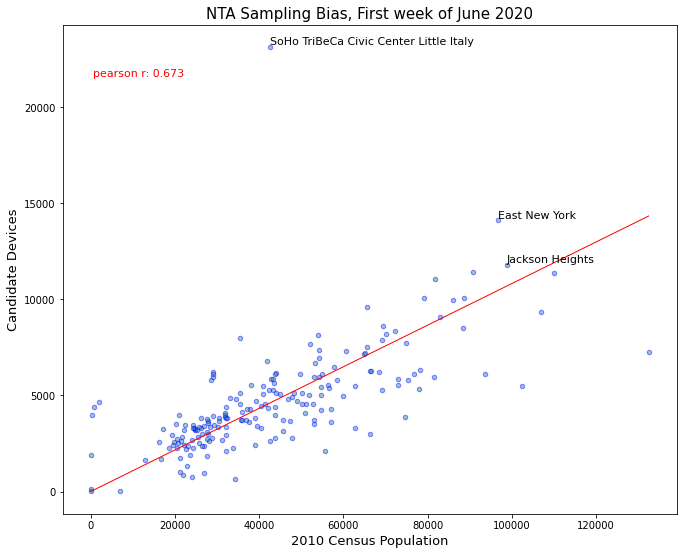

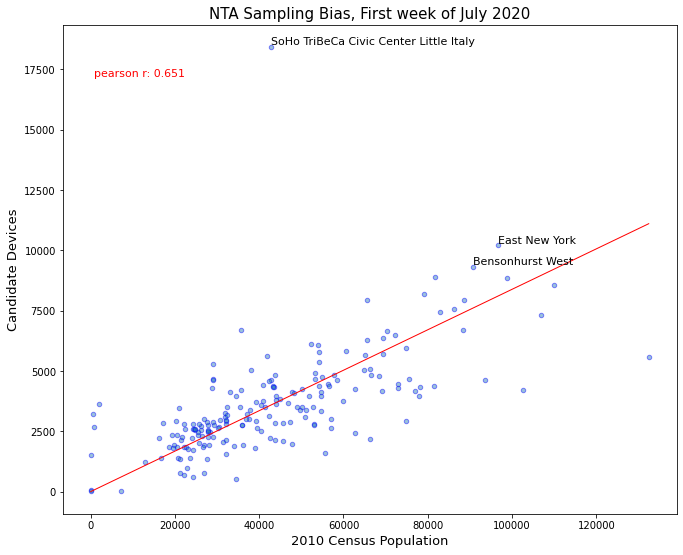

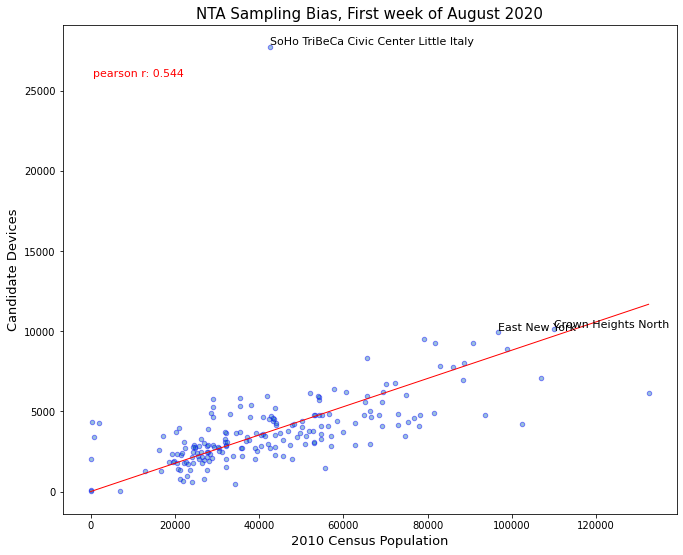

In [43]:
# using the scatter plot function within the for loop.
for m, mn in month_dict.items():
    dff = df_nta[df_nta['month'].isin([m])] # specifies each month to be shown separately
    make_scatter_candidate(dff, mn)

In [44]:
# same process, for device count
def make_scatter_device_ct(df, month):
    print('NTA-level sampling bias')
    alpha_level = 0.45 # point transparency, 45%
    ax = plot_sg_vs_geos(df, 'Pop_E', 'device_count', bias_col = 'abs_bias_device', num_to_label = 3, text_col = 'name',alpha = alpha_level)
    ax.set_title(f'NTA Sampling Bias, First week of {mn} 2020', color = 'k',  fontsize = 15)
    ax.set_xlabel(xlabel = '2010 Census Population',color = 'k',  fontsize = 13)
    ax.set_ylabel(ylabel = 'Device Count', color = 'k',  fontsize = 13)
    plt.savefig(f'scatterplots/NTA_device_scatter_{mn}.jpg') # saving each scatter plot by month

NTA-level sampling bias
pearson r: 0.868
Sum Absolute Bias: 2.49
NTA-level sampling bias
pearson r: 0.844
Sum Absolute Bias: 3.12
NTA-level sampling bias
pearson r: 0.844
Sum Absolute Bias: 2.98
NTA-level sampling bias
pearson r: 0.802
Sum Absolute Bias: 2.88
NTA-level sampling bias
pearson r: 0.767
Sum Absolute Bias: 3.12
NTA-level sampling bias
pearson r: 0.757
Sum Absolute Bias: 3.22
NTA-level sampling bias
pearson r: 0.747
Sum Absolute Bias: 3.31
NTA-level sampling bias
pearson r: 0.677
Sum Absolute Bias: 3.62


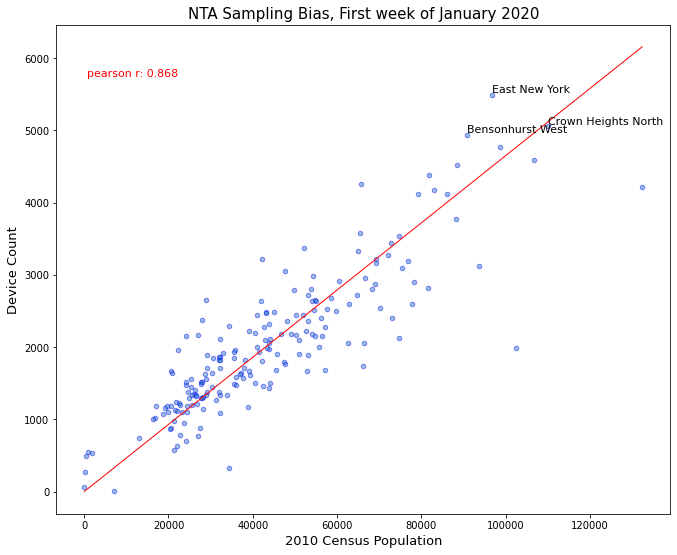

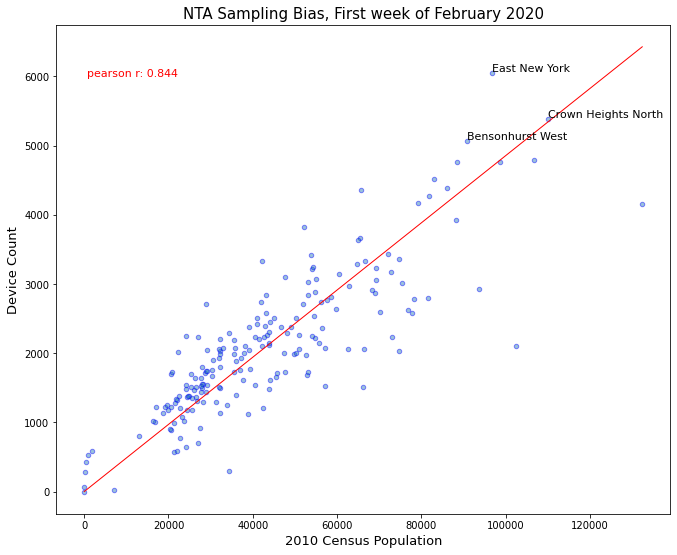

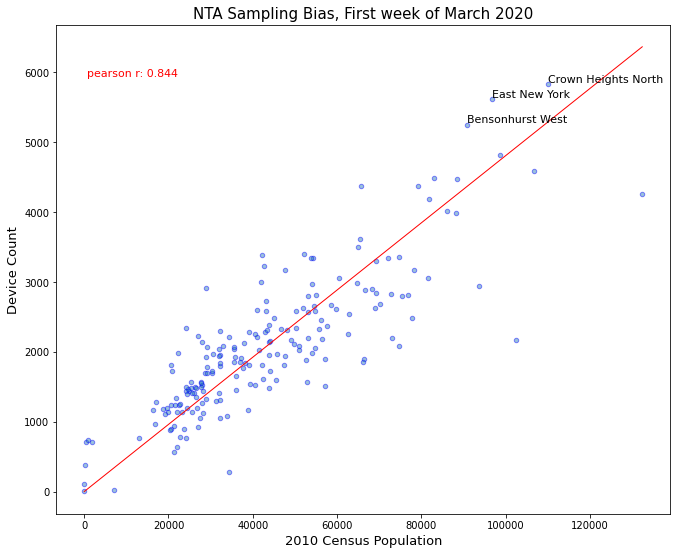

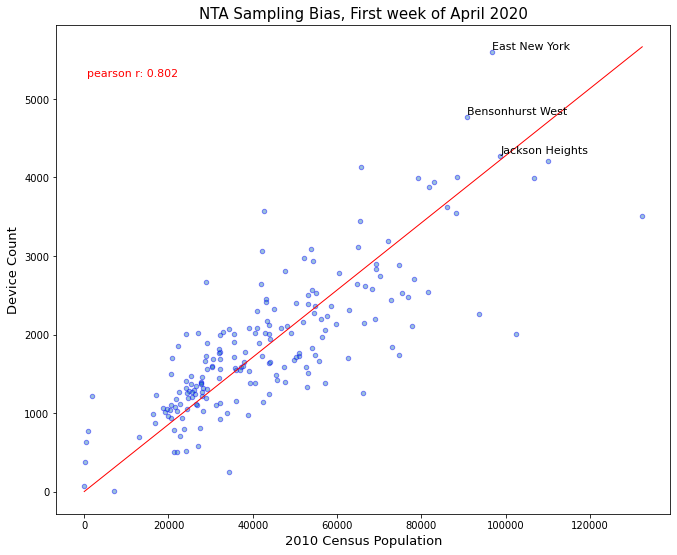

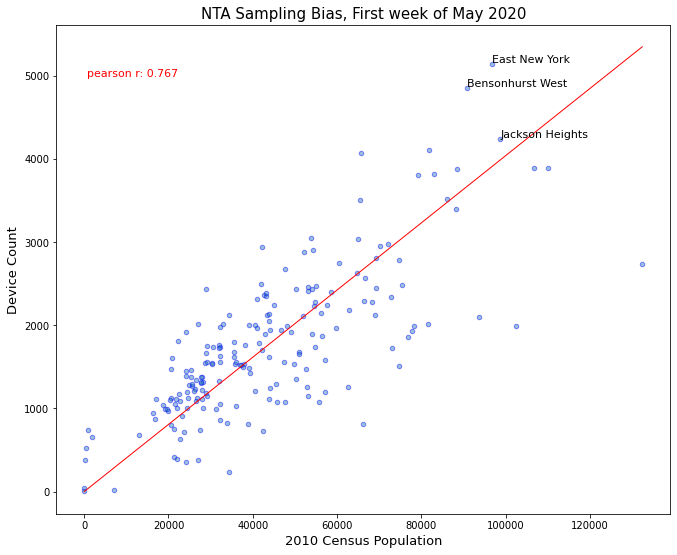

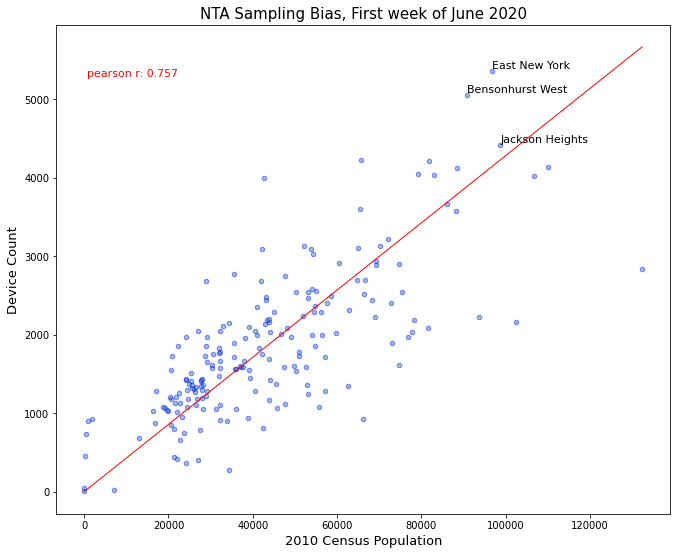

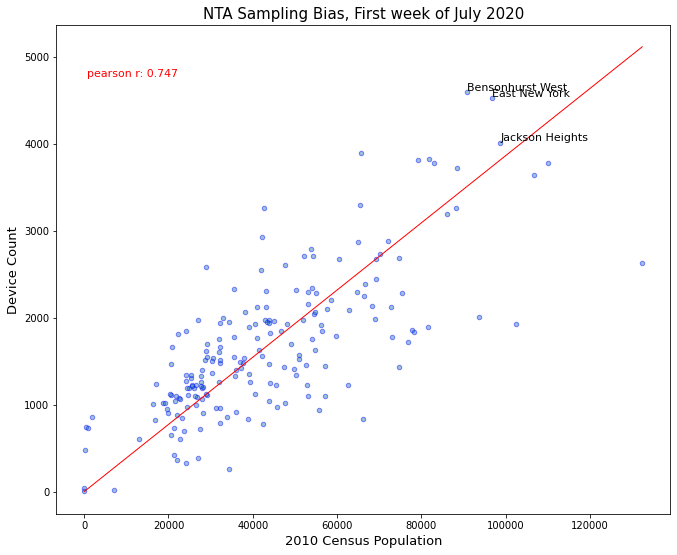

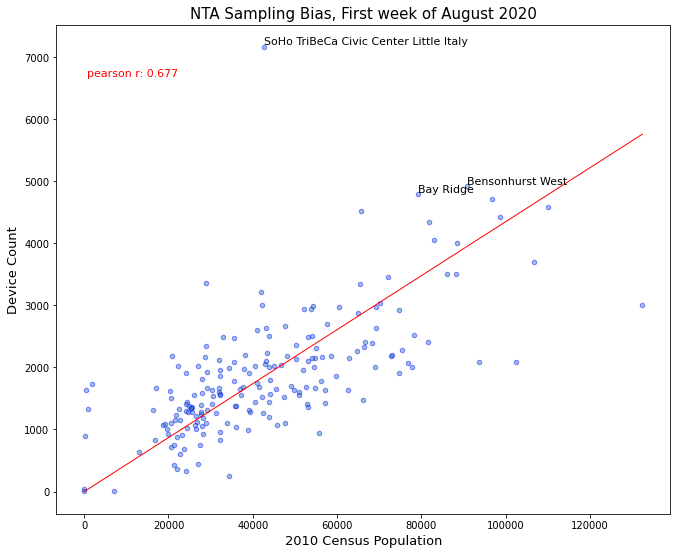

In [45]:
for m, mn in month_dict.items():
    dff = df_nta[df_nta['month'].isin([m])]
    make_scatter_device_ct(dff, mn)


In [254]:
# save dataframes as csv
# January to August
df_nta.to_csv(r'output_csv\dfnta_bias.csv', index = False)
